<center>
    <h1>Inteligencia Artificial</h1>
    <h1>Regresión Lineal 5</h1>
    <h1></h1>
    <h5>Prof. Wladimir Rodriguez</h5>
    <h5>wladimir.rodriguez@outlook.com</h5>
    <h5>Departamento de Computación</h5>
</center>

# Regresión Lineal Regularizada II

## Selección del parámetro de penalización l2 (alfa) en la Regresión Lineal Ridge

## Validación Cruzada y Selección de Atributos

Al igual que el grado polinomial, la penalización L2 es un parámetro "mágico" que debemos seleccionar. Podríamos utilizar el enfoque de validación como lo hicimos en anteriormente, pero ese enfoque tiene una gran desventaja: deja menos observaciones disponibles para el entrenamiento. La validación cruzada busca superar este problema utilizando todo el conjunto de entrenamiento de una manera inteligente.

<img src="../figuras/division_datos.png" width="75%">

Implementaremos una especie de validación cruzada llamada validación cruzada "k-fold". El método obtiene su nombre porque implica dividir el conjunto de entrenamiento en k segmentos de tamaño prácticamente igual. Similar al método del conjunto de validación, medimos el error de validación con uno de los segmentos designados como el conjunto de validación. 

La diferencia principal es que repetimos el proceso k veces de la siguiente manera:

- Seleccione el segmento 0 como el conjunto de validación y ajuste un modelo en el resto de los datos y evalúelo con  este conjunto de validación
- Seleccione el segmento 1 como el conjunto de validación y ajuste un modelo en el resto de los datos y evalúelo con este conjunto de validación
- ...
- Seleccione el segmento k-1 como el conjunto de validación y ajuste un modelo en el resto de los datos y evalúelo con este conjunto de validación

![](../figuras/validacion_cruzada.png)

Después de este proceso, calculamos el promedio de los k errores de validación, y lo usamos como una estimación del error de generalización. Observe que todas las observaciones se usan tanto para el entrenamiento como para la validación, a medida que iteramos sobre segmentos de datos.

Para estimar bien el error de generalización, es crucial mezclar los datos de entrenamiento antes de dividirlos en segmentos. Reservamos el 10% de los datos como conjunto de prueba y barajamos el resto. (Asegúrese de usar random_state = 0 para obtener una respuesta consistente.)

In [21]:
import math
import random
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

### Lectura de los datos

In [22]:
ventas = pd.read_csv('../datos/kc_house_data.csv')
ventas = shuffle(ventas)
atributos = list(ventas)
atributos.remove('price')
atributos.remove('date')
atributos.remove('id')

### Dividir los datos en dos conjuntos uno de entrenamiento y validación y el otro de prueba

In [23]:
ventas_entre_val, ventas_prueba = train_test_split(ventas, test_size=0.1, random_state=0)
ventas_entre_val.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
5742,1224049005,20140708T000000,1087500.0,2,2.0,2360,11340,1.5,0,0,...,9,2360,0,1997,0,98040,47.5835,-122.227,3030,11340
12582,7625703405,20140910T000000,431000.0,2,1.0,1000,6500,1.0,0,0,...,7,1000,0,1918,0,98136,47.5474,-122.388,1280,6500
13095,1231000458,20140720T000000,666570.0,4,2.0,2320,7400,1.5,0,0,...,7,1620,700,1913,0,98118,47.5558,-122.269,1740,4000
20262,7787920250,20150501T000000,550000.0,4,2.5,3220,9328,2.0,0,0,...,8,3220,0,2006,0,98019,47.7273,-121.958,3020,9300
10954,510002010,20140630T000000,875000.0,4,1.5,1800,3245,1.5,0,0,...,8,1800,0,1929,0,98103,47.6605,-122.331,1800,4275


### Crear los segmentos del conjunto de entrenamiento y validación 
Una vez que los datos son barajados, lo dividimos en segmentos iguales. Cada segmento debe recibir `n/k` elementos, donde `n` es el número de observaciones en el conjunto de entrenamiento y `k` es el número de segmentos. Puesto que el segmento 0 comienza en el índice 0 y contiene `n/k` elementos, termina en el índice `(n/k)-1`. El segmento 1 comienza donde el segmento 0 se detuvo, en el índice `(n/k)`. Con `n/k` elementos, el segmento 1 termina en el índice `(n*2/k)-1`. Continuando de esta manera, deducimos que el segmento `i` comienza en el índice `(n*i/k)` y termina en `(n*(i+1)/k)-1`.
Con este patrón en mente, escribimos un lazo corto que imprime los índices inicial y final de cada segmento, sólo para asegurarse de que está haciendo las divisiones correctas.

In [24]:
n = len(ventas_entre_val)
k = 10 # validación cruzada 10-fold

for i in range(k):
    inicio = (n*i)//k
    fin = (n*(i+1))//k-1
    print(i, (inicio, fin))

0 (0, 1944)
1 (1945, 3889)
2 (3890, 5834)
3 (5835, 7779)
4 (7780, 9724)
5 (9725, 11669)
6 (11670, 13614)
7 (13615, 15559)
8 (15560, 17504)
9 (17505, 19450)


### Definiciones de algunas funciones de utilidad

In [25]:
def imprimir_coefficientes(modelo):    
    # Obtener el grado del polinomio
    grado = len(modelo.coef_)

    # Obtener los parámetros aprendidos como una lista
    w = [modelo.intercept_]
    w += (modelo.coef_).tolist()
    # Numpy tiene un a función para imprimir polinomios de manera elegante
    # (La usaremos, pero necesita los parámetros en orden inverso)
    print ('Polinomio de grado ' + str(grado) + ':')
    w.reverse()
    print (np.poly1d(w))

Ahora implementaremos la validación cruzada k-fold. Definiremos una función que calcule los k errores de validación designando cada uno de los k segmentos como el conjunto de validación. Acepta como parámetros (i) `k`, (ii)` penalidad_l2`, (iii) los datos de entrenamiento, (iv) la salida (v) lista de atributos. La función devuelve el error de validación medio usando k segmentos como conjuntos de validación.

* Para cada `i` en `[0, 1, ..., k-1]`:
   * Calcular los índices de inicio y fin del segmento i y llamar 'inicio' y 'fin'
   * Crear el conjunto de validación tomando una porción `(inicio: fin + 1)` de los datos.
   * Crear el conjunto entrenamiento fijado añadiendo la rebanada `(fin + 1: n)` al final de la rebanada `(0: inicio)`.
   * Entrenar un modelo lineal usando un conjunto de entrenamiento recién formado, con una `penalidad_l2` dada
   * Calcule el error de validación usando el conjunto de validación recién creado

In [26]:
def validacion_cruzada_k_fold(algoritmo, k, penalidad_l2, data, salida, lista_atributos):
    n = len(data)
    rss = 0
    mse = 0
    modelo = algoritmo(alpha=penalidad_l2)
    X = data[lista_atributos]
    y = data[salida]
    for i in range(k):
        inicio = (n*i)//k
        fin = (n*(i+1))//k-1
        X_validacion = X[inicio: fin+1]
        y_validacion = y[inicio: fin+1]
        X_entrenamiento = X[0:inicio]
        y_entrenamiento = y[0:inicio]
        ultimo_X = X[fin+1:n]
        ultimo_y = y[fin+1:n]
        X_entrenamiento = X_entrenamiento.append(ultimo_X)
        y_entrenamiento = y_entrenamiento.append(ultimo_y)
        modelo.fit(X_entrenamiento, y_entrenamiento)
        mse += mean_squared_error(y_validacion, modelo.predict(X_validacion))
    mse = mse / k
    return mse

Una vez que tenemos una función para calcular el error de validación promedio de un modelo, podemos escribir un lazo para encontrar el modelo que minimiza el error de validación promedio. Escriba un lazo que haga lo siguiente:
Estaremos nuevamente ajustando un modelo polinomial de grado 15 usando la entrada `sqft_living`
Con la `penalidad_l2` en `[10^1, 10^1.5, 10^2, 10^2.5, ..., 10^7]` (para obtener esto en Python, puede utilizar esta función Numpy: `np.logspace(1, 7, Num = 13)`
Ejecutar validación cruzada de 10-fold con `penalidad_l2`
Informe qué penalización de L2 produjo el error de validación promedio más bajo.

In [27]:

penalidad_l2 = np.logspace(-1, 0.1, num=20)
mse = np.empty(len(penalidad_l2))
data = ventas_entre_val[atributos]
mis_atributos = list(data)
data['price'] = ventas_entre_val['price']
for i in range(len(penalidad_l2)):
    mse[i] = validacion_cruzada_k_fold(Ridge, 10, penalidad_l2[i], data, 'price', atributos)
print (mse)
print (min(mse))
    


[4.15359305e+10 4.15359283e+10 4.15359260e+10 4.15359236e+10
 4.15359210e+10 4.15359184e+10 4.15359158e+10 4.15359134e+10
 4.15359113e+10 4.15359097e+10 4.15359091e+10 4.15359100e+10
 4.15359128e+10 4.15359187e+10 4.15359287e+10 4.15359444e+10
 4.15359680e+10 4.15360023e+10 4.15360509e+10 4.15361186e+10]
41535909130.490944


Graficar el error de validación con respecto al valor de la penalización

alfa =  0.37926901907322497
MSE = 41535909130.490944


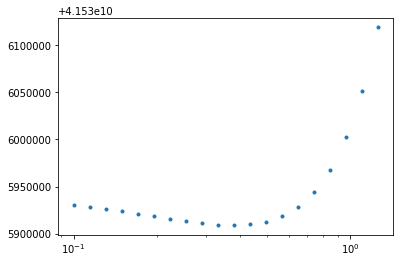

In [28]:
# Graficar los valores de la penalizacion_l2 en el eje xy el error de validación cruzada en el eje y.
# El uso de plt.xscale ('log') hará que su trazado sea más intuitivo. 
alfa = penalidad_l2[np.argmin(mse)]
print('alfa = ', alfa )
print('MSE =', mse[np.argmin(mse)])
plt.plot(penalidad_l2, mse,'.')
plt.xscale('log')

Una vez que encuentre el mejor valor para la penalización L2 mediante la validación cruzada, es importante reentrenar un modelo final con todos los datos de entrenamiento usando este valor de `penalizacion_l2`. De esta manera, su modelo final será entrenado con el conjunto de datos completo.

In [29]:
modeloRidge = Ridge(alpha=alfa)
X = ventas_entre_val[atributos]
y = ventas_entre_val['price']
X_prueba = ventas_prueba[atributos]
y_prueba = ventas_prueba['price']
modeloRidge.fit(X, y)
mse = mean_squared_error(y_prueba, modeloRidge.predict(X_prueba))
print('MSE =', mse )
imprimir_coefficientes(modeloRidge)

MSE = 34484087107.21842
Polinomio de grado 18:
         18         17             16             15         14
-0.3837 x  + 17.42 x  - 2.164e+05 x  + 6.026e+05 x  - 603.3 x 
          13        12         11         10             9
 + 20.99 x  - 2624 x  + 38.83 x  + 72.64 x  + 9.649e+04 x
              8            7             6        5         4         3
 + 2.644e+04 x + 5.59e+04 x + 5.995e+05 x + 6467 x + 0.114 x + 111.5 x
              2
 + 4.193e+04 x - 3.624e+04 x + 8.55e+06


### Valor de los coefficientes con respecto al valor de la penalización. Regresión Lineal Ridge

Los valores de los coeeficientes tienden a cero a medida que se incrementa el valor de la penalización (alfa)

<img src="../figuras/ridge_coefficientes.png" width="75%">


Contornos de la función de penalización y el error para la Regresión Lineal Ridge

<img src="../figuras/estimacion_ridge.png" width="75%">

In [30]:
modeloLR = LinearRegression()
modeloLR.fit(X, y)
mse = mean_squared_error(y_prueba, modeloLR.predict(X_prueba))
print('MSE =', mse )
imprimir_coefficientes(modeloLR)

MSE = 34488638294.703255
Polinomio de grado 18:
         18         17             16             15         14
-0.3835 x  + 17.43 x  - 2.168e+05 x  + 6.033e+05 x  - 604.1 x 
          13        12        11         10             9             8
 + 20.98 x  - 2623 x  + 38.8 x  + 72.65 x  + 9.647e+04 x + 2.645e+04 x
              7             6        5          4         3
 + 5.583e+04 x + 6.014e+05 x + 6434 x + 0.1143 x + 111.5 x
              2
 + 4.193e+04 x - 3.623e+04 x + 8.544e+06


## Selección de Atributos Usando Regresión Lasso

In [31]:
def seleccion_atributos(k, penalidad_l1, data, salida, lista_atributos):
    n = len(data)
    mse = 0
    modelo = Lasso(alpha=penalidad_l1)
    X = data[lista_atributos]
    y = data[salida]
    for i in range(k):
        inicio = (n*i)//k
        fin = (n*(i+1))//k-1
        X_validacion = X[inicio: fin+1]
        y_validacion = y[inicio: fin+1]
        X_entrenamiento = X[0:inicio]
        y_entrenamiento = y[0:inicio]
        ultimo_X = X[fin+1:n]
        ultimo_y = y[fin+1:n]
        X_entrenamiento = X_entrenamiento.append(ultimo_X)
        y_entrenamiento = y_entrenamiento.append(ultimo_y)
        modelo.fit(X_entrenamiento, y_entrenamiento)
        mse += mean_squared_error(y_validacion, modelo.predict(X_validacion))
    mse = mse / k
    return mse

In [33]:
penalidad_l1 = np.logspace(-1, 0.7, num=10)
mse = np.empty(len(penalidad_l1))
data = ventas_entre_val[atributos]
data['price'] = ventas_entre_val['price']
for i in range(len(penalidad_l1)):
    mse[i] = validacion_cruzada_k_fold(Lasso, 10, penalidad_l1[i], data, 'price', atributos)
print (mse)

[4.15359504e+10 4.15359513e+10 4.15359528e+10 4.15359552e+10
 4.15359588e+10 4.15359644e+10 4.15359733e+10 4.15359872e+10
 4.15360094e+10 4.15360452e+10]


alfa =  5.011872336272722
MSE = 41535950365.28935


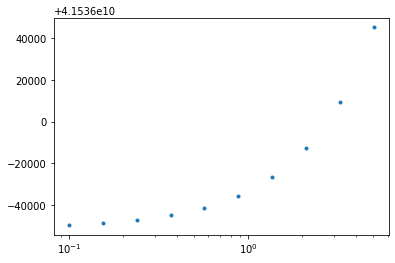

In [34]:
# Graficar los valores de la penalizacion_l1 en el eje xy el error de validación cruzada en el eje y.
# El uso de plt.xscale ('log') hará que su trazado sea más intuitivo. 
alfa = penalidad_l1[np.argmax(mse)]
print('alfa = ', alfa )
print('MSE =', mse[np.argmin(mse)])
plt.plot(penalidad_l1, mse,'.')
plt.xscale('log')

In [35]:
modeloLasso = Lasso(alpha=5000000)
modeloLasso.fit(X, y)
mse = mean_squared_error(y_prueba, modeloLasso.predict(X_prueba))
print('MSE =', mse )
imprimir_coefficientes(modeloLasso)

MSE = 53870184064.55438
Polinomio de grado 18:
         18         17     16         13     12         11     10
-0.7241 x  + 61.44 x  - 0 x  + 53.82 x  - 0 x  + 3.027 x  - 0 x 
           4         3
 + 0.0518 x + 244.2 x - 0 x - 8.54e+04


### Valor de los coefficientes con respecto al valor de la penalización. Regresión Lineal Lasso

Los valores de los coeeficientes se van haciendo igual a cero a medida que se incrementa el valor de la penalización (alfa)

<img src="../figuras/lasso_coefficientes.png" width="75%">


Contornos de la función de penalización y el error para la Regresión Lineal Lasso

<img src="../figuras/estimacion_lasso.png" width="75%">